# Import libraries needed

In [1]:
from datetime import datetime as dt
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from statsmodels.tsa.arima_model import ARIMA
from pylab import rcParams

# Helper functions

In [38]:
# prepare the raw dataset for predictions
def prepareDf(df, created, date):
    df = df[df[created].notnull()]
    df[date] = pd.to_datetime(df[created].apply(lambda x: pd.to_datetime(x).strftime('%m/%d/%Y')))
    df = df.set_index(date)
    df_pred = df.groupby(date).size().reset_index(name = 'actual')
    df_pred = df_pred.set_index(date)
    y = df_pred['actual'].resample('W').mean()
    # for applications, we use y = df_pred['actual'].resample('MS').mean() instead
    return df_pred.index, y

In [3]:
# plot the decomposition
def decompositionPlot(y):
    rcParams['figure.figsize'] = 18, 8
    decomposition = sm.tsa.seasonal_decompose(y, model = 'additive')
    fig = decomposition.plot()
    plt.show()
    return fig

In [4]:
# choose the best parameters
def chooseParams():
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y, order=param, 
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue

In [5]:
# fitting model with best parameters
def fitModel(y, pdq, seasonal_pdq):
    mod = sm.tsa.statespace.SARIMAX(y, order = pdq, seasonal_order = seasonal_pdq, 
                                    enforce_stationarity=False, enforce_invertibility=False)
    results = mod.fit()
    return results

In [6]:
# plot test fitting
def testFitting(model, starting_point):
    pred = model.get_prediction(start = pd.to_datetime(starting_point), dynamic = False)
    pred_ci = pred.conf_int()
    ax = y['2018':].plot(label='observed')
    fig = pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of applications')
    plt.legend()
    plt.show()
    return pred, fig

In [36]:
# predict
def actualPred(model):
    pred = results.get_forecast(steps = 10) # steps is usually 5 for monthly
    pred_ci = pred.conf_int()
    ax = y.plot(label='observed', figsize = (14, 7))
    fig = pred.predicted_mean.plot(ax = ax, label = 'Forecast')
    ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of applications')
    plt.legend()
    return fig, pred.predicted_mean

# Read the raw dataset and prepare for prediction

In [39]:
ba = pd.read_csv("example.csv", sep=';', delimiter=None, header='infer')
created = 'date_live'
date = 'date'
_, y = prepareDf(ba, created, date)

In [40]:
y

date
2018-01-21     1.0
2018-01-28     NaN
2018-02-04     NaN
2018-02-11     NaN
2018-02-18     NaN
              ... 
2019-12-08    34.6
2019-12-15    48.0
2019-12-22    41.0
2019-12-29     2.0
2020-01-05    38.0
Freq: W-SUN, Name: actual, Length: 103, dtype: float64

# Plot the decompositions and observe

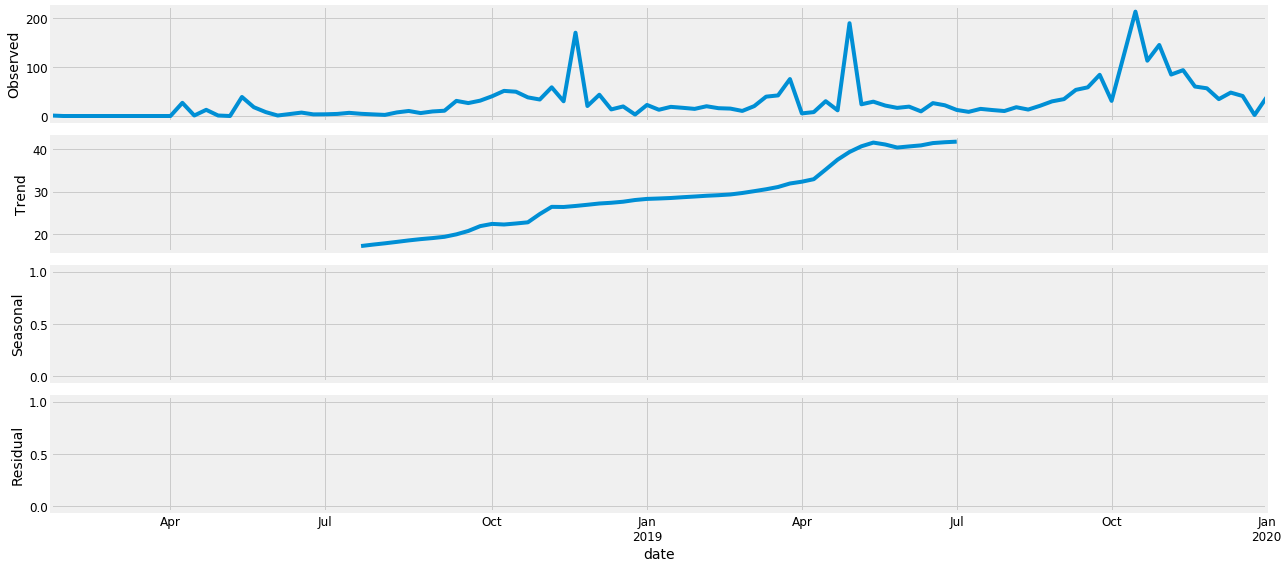

In [41]:
y = y.fillna(0) # not needed for applications
fig = decompositionPlot(y)

# Choose the best parameters

In [42]:
chooseParams()

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1086.4821249222184
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:967.3378194240975
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:973.2489493028835
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:825.0343482283143
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:969.8497962083153
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:939.1386703637188
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:824.3666221830072
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:816.6249693484691
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1048.6941427975771
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:934.1126875772346
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:953.2906885333773
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:807.2579474470143
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:950.1653878312172
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:925.3546962827173
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:823.857035159118
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:805.2753534572463
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1032.1117410988045
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:921.7738941990938
ARIMA(0,

# Fitting models with best parameters

In [43]:
y = y
pdq = (1, 1, 1)
seasonal_pdq = (1, 1, 1, 12)
results = fitModel(y, pdq, seasonal_pdq)

In [44]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4281      0.121     -3.551      0.000      -0.664      -0.192
ma.L1         -0.4641      0.133     -3.501      0.000      -0.724      -0.204
ar.S.L12      -0.6022      0.187     -3.220      0.001      -0.969      -0.236
ma.S.L12      -0.3349      0.247     -1.355      0.175      -0.819       0.150
sigma2      1369.0859    116.435     11.758      0.000    1140.877    1597.295


ValueError: operands could not be broadcast together with shapes (9,) (8,) (9,) 

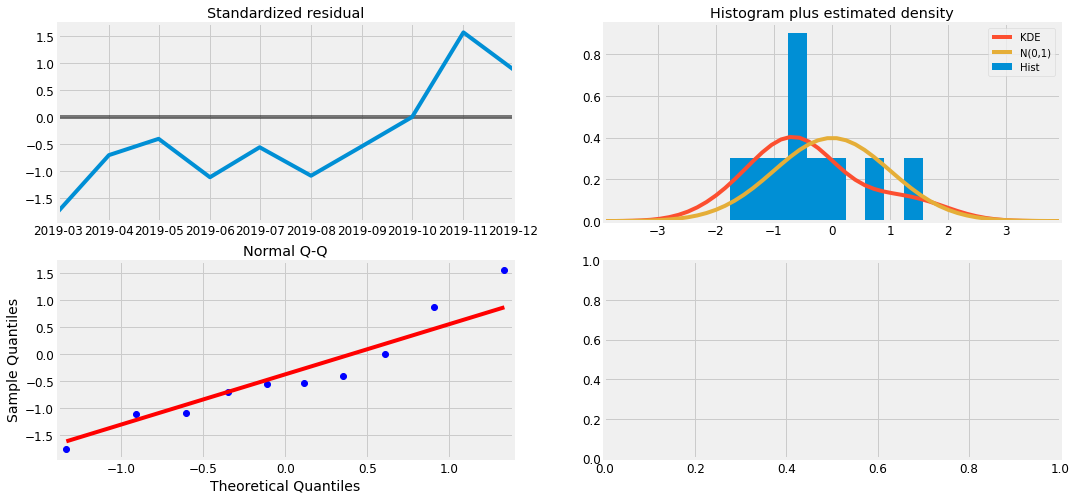

In [17]:
# plot some diagnostics graphs, which is commented out because it will interrupt the whole kernel.
# when necessary or of interest, just cancel the comments and all will be fine.
# diagnostics = results.plot_diagnostics(figsize=(16, 8))
# plt.show()

# Test the fitting with part of the dataset

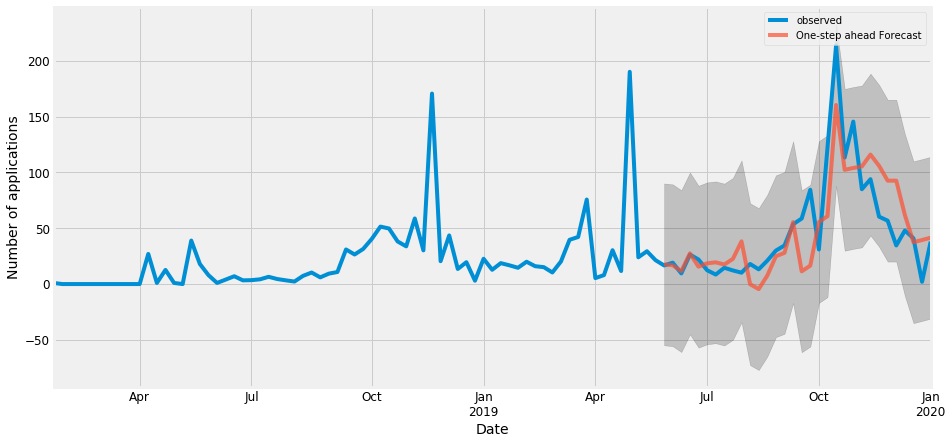

In [45]:
# starting_point = '2019-06-01' (for monthly start average)
# model = results
pred, plot = testFitting(results, '2019-06-02')

The predicted part fits well with the observed part.

In [46]:
# check the stats
y_forecasted = pred.predicted_mean
y_truth = y['2019-06-02':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 850.42
The Root Mean Squared Error of our forecasts is 29.16


# Prediction!

(<matplotlib.axes._subplots.AxesSubplot at 0x24b25eb0400>,
 2020-01-12    68.046339
 2020-01-19    33.598231
 2020-01-26    36.005438
 2020-02-02    28.764643
 2020-02-09    32.797280
 2020-02-16    38.504021
 2020-02-23    38.927469
 2020-03-01    55.804107
 2020-03-08    53.754729
 2020-03-15    67.634879
 Freq: W-SUN, dtype: float64)

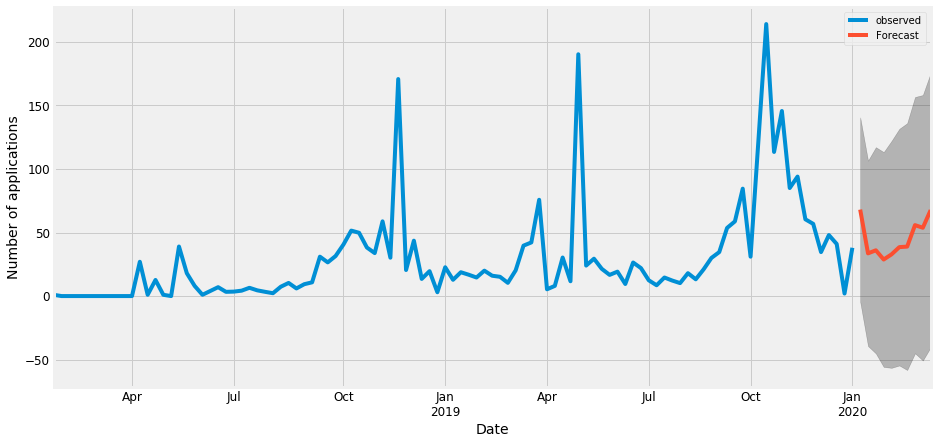

In [47]:
actualPred(results)